In [1]:
import requests, re, pandas as pd, numpy as np
from itertools import product
from bs4 import BeautifulSoup as bs
from scipy import stats
import pandas as pd
import numpy as np
from datetime import datetime
from xgboost import XGBClassifier, XGBRegressor
import utils

In [2]:
import os
import pickle
from datetime import datetime
def ensure_folder_exists(folder_path):
    """
    Creates the specified folder if it does not already exist
    """
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)


def load_pickle(file_path):
    """
    Loads a pickle from the file system
    """
    return pickle.load(open(file_path, 'rb')) if os.path.isfile(file_path) else None


def save_pickle(file_path, data):
    """
    Saves the specified object as a pickle to the file system
    """
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)


In [4]:
all_ads = []
for i in range(117):
    target = f'Y:/Internship/SoMin/Notebook/raw/20220526/adlibrary_ads_us_90_days_{i}.pkl'
    if os.path.getsize(target) > 0: 
        ads = load_pickle(target)
        print(f'Retrieve from package {i}, with {len(ads)} ads')
        all_ads.extend(ads)
    else:
        print('empty')
print(f'Retrieve {len(all_ads)} in total')

Retrieve from package 0, with 39846 ads
Retrieve from package 1, with 19032 ads
Retrieve from package 2, with 30964 ads
Retrieve from package 3, with 15915 ads
Retrieve from package 4, with 18715 ads
Retrieve from package 5, with 14153 ads
Retrieve from package 6, with 6128 ads
Retrieve from package 7, with 11033 ads
Retrieve from package 8, with 7118 ads
Retrieve from package 9, with 17429 ads
Retrieve from package 10, with 6725 ads
Retrieve from package 11, with 14015 ads
Retrieve from package 12, with 5588 ads
Retrieve from package 13, with 7388 ads
Retrieve from package 14, with 3606 ads
Retrieve from package 15, with 2149 ads
Retrieve from package 16, with 7456 ads
Retrieve from package 17, with 1509 ads
Retrieve from package 18, with 3453 ads
Retrieve from package 19, with 4449 ads
Retrieve from package 20, with 940 ads
Retrieve from package 21, with 470 ads
Retrieve from package 22, with 535 ads
Retrieve from package 23, with 335 ads
Retrieve from package 24, with 365 ads
Retrie

In [5]:
print(len(all_ads))

349951


In [9]:
def get_image_url(source):
    """
    function to extract image_url from the retreived data from Ad Library API
    Why?: the URL obtained via the endpoint is not an image_url but instead a url for a snapshot of the entire ad
    """
    pattern = r'"resized_image_url":"(?:\\.|[^"\\])*"' # find resized_image_url : <image_url>
    img_url = re.findall(pattern, str(source))[0].split('"resized_image_url":')[1].replace('\\', '').replace('"', '').replace("'", '')
    return img_url

def process_ads(ads):
    """
    processes Ads retrieved from Ads Archive (FB Ad Library)
    """
    df = pd.DataFrame(ads)    
    clean = []
    for _, row in df.iterrows():
        m = {}
#         m['search_term'] = row['topic']
        m['country'] = row['country']
        m['page_id'] = row['page_id']
        m['page_name'] = row['page_name']
        
        m['ad_id'] = row['id']
        
        m['ad_creation_date'] = row['ad_creation_time']
        if m['ad_creation_date'] is np.nan:
            continue
        m['ad_creation_month'] = int(m['ad_creation_date'][5:7])
        
        
        m['delivery_start'] = row['ad_delivery_start_time']
        if m['delivery_start'] is np.nan:
            continue
            
        m['delivery_stop'] = row['ad_delivery_stop_time']
        if m['delivery_stop'] is np.nan:
            continue
        
        start = datetime.strptime(m['delivery_start'], '%Y-%m-%d')
        stop = datetime.strptime(m['delivery_stop'], '%Y-%m-%d')
        m['delivery_period'] = (stop-start).days
        
        m['ad_url'] = row['ad_snapshot_url']
        
#         try:
#             source = soup(requests.get(row['ad_snapshot_url']).content, 'html.parser')
#             m['image_url'] = get_image_url(source)
#         except:
#             m['image_url'] = np.nan # some ads are wrongly classified as having images
        
        ad_body = row['ad_creative_bodies']
        m['ad_body'] = ad_body[0] if (type(ad_body) == list) else ''
        m['uses_multi_body'] = 1 if ((type(ad_body) == list) and (len(set(ad_body)) > 1)) else 0
        
        link_capt = row['ad_creative_link_captions']
        m['link_caption'] = link_capt[0] if (type(link_capt) == list) else ''
        m['uses_multi_capt'] = 1 if ((type(link_capt) == list) and (len(set(link_capt)) > 1)) else 0
        
        link_title = row['ad_creative_link_titles']
        m['link_title'] = link_title[0] if (type(link_title) == list) else ''
        m['uses_multi_title'] = 1 if ((type(link_title) == list) and (len(set(link_title)) > 1)) else 0
        
        link_desc = row['ad_creative_link_descriptions']
        m['link_description'] = link_desc[0] if (type(link_desc) == list) else ''
        m['uses_multi_desc'] = 1 if ((type(link_desc) == list) and (len(set(link_desc)) > 1)) else 0
        
        lang = row['languages']
        m['language'] = ','.join(lang) if (type(lang) == list) else ''
        m['uses_multi_lang'] = 1 if ((type(lang) == list) and (len(set(lang)) > 1)) else 0
        
        m['funded_by'] = row['bylines'] if type(row['bylines']) == str else ''
        m['currency'] = row['currency']
        
        spend = row['spend']
        m['min_spend'] = spend.get('lower_bound', np.nan)
        m['max_spend'] = spend.get('upper_bound', np.nan)
        
        impressions = row['impressions']
        m['min_impressions'] = impressions.get('lower_bound', np.nan)
        m['max_impressions'] = impressions.get('upper_bound', np.nan)
        
        audience_size = row['estimated_audience_size']
        m['min_audience_size'] = audience_size.get('lower_bound', np.nan) if type(audience_size)==dict else np.nan
        m['max_audience_size'] = audience_size.get('upper_bound', np.nan) if type(audience_size)==dict else np.nan
        
        
        if m['max_impressions'] is np.nan or m['min_impressions'] is np.nan: 
            m['impressions'] = 0
            continue
        else:
            m['impressions'] = (int(m['max_impressions']) + int(m['min_impressions']))/2
            
        if m['max_spend'] is np.nan or m['min_spend'] is np.nan: 
            m['spend'] = 0
            continue
        else:
            m['spend'] = (int(m['max_spend']) + int(m['min_spend']))/2
        
        
        if m['max_impressions'] is np.nan or m['max_impressions'] == 0:
            m['CPM'] = 0
            continue
        else:
            m['CPM'] = int(m['max_spend']) / int(m['max_impressions']) * 1000
        
        
        if m['max_impressions'] is np.nan or m['max_impressions'] == 0:
            m['CPM2'] = 0
            continue
        else:
            m['CPM2'] = int(m['spend']) / int(m['impressions']) * 1000
        
        
        
        platforms = row['publisher_platforms']
        m['facebook'] = 1 if ((type(platforms) == list) and ('facebook' in platforms)) else 0
        m['instagram'] = 1 if ((type(platforms) == list) and ('instagram' in platforms)) else 0
        m['messenger'] = 1 if ((type(platforms) == list) and ('messenger' in platforms)) else 0
        m['audience_network'] = 1 if ((type(platforms) == list) and ('audience_network' in platforms)) else 0
        
        m['demographic_dist'] = row['demographic_distribution']
        clean.append(m)
        
    return pd.DataFrame(clean)

In [10]:
# start = datetime.strptime('2022-03-12', '%Y-%m-%d')
# stop = datetime.strptime('2022-04-16', '%Y-%m-%d')
# type((stop-start).days)

In [11]:
df = process_ads(all_ads)
df

,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,ad_url,...,max_audience_size,impressions,spend,CPM,CPM2,facebook,instagram,messenger,audience_network,demographic_dist
0,GB,5662929773,openDemocracy,697826204986544,2022-03-21,3,2022-03-22,2022-03-28,6,https://www.facebook.com/ads/archive/render_ad...,...,NaN,17499.5,49.5,4.950248,2.800160,1,1,0,0,"[{'percentage': '8.7E-5', 'age': '18-24', 'gen..."
1,GB,5662929773,openDemocracy,717070192589918,2021-12-20,12,2021-12-20,2021-12-27,7,https://www.facebook.com/ads/archive/render_ad...,...,NaN,12499.5,49.5,6.600440,3.920314,1,1,0,0,"[{'percentage': '0.005992', 'age': '65+', 'gen..."
2,GB,5662929773,openDemocracy,379386380646054,2021-11-24,11,2021-11-24,2021-11-28,4,https://www.facebook.com/ads/archive/render_ad...,...,NaN,27499.5,49.5,3.300110,1.781883,1,1,0,0,"[{'percentage': '0.001034', 'age': '45-54', 'g..."
3,GB,5662929773,openDemocracy,507993067164214,2021-08-06,8,2021-08-07,2021-08-10,3,https://www.facebook.com/ads/archive/render_ad...,...,NaN,12499.5,49.5,6.600440,3.920314,1,1,0,0,"[{'percentage': '0.005187', 'age': '55-64', 'g..."
4,GB,5662929773,openDemocracy,445846929800097,2021-02-22,2,2021-02-22,2021-02-26,4,https://www.facebook.com/ads/archive/render_ad...,...,1000000,2499.5,49.5,33.011004,19.607843,1,1,0,0,"[{'percentage': '0.00634', 'age': '65+', 'gend..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63960,GB,2998477143711696,Gareth for Radcliffe West,593654441186107,2020-03-08,3,2020-03-08,2020-03-15,7,https://www.facebook.com/ads/archive/render_ad...,...,NaN,3499.5,49.5,24.756189,14.004001,1,0,0,0,"[{'percentage': '0.023936', 'age': '65+', 'gen..."
63961,GB,2998477143711696,Gareth for Radcliffe West,1656485304494240,2020-01-10,1,2020-01-11,2020-01-13,2,https://www.facebook.com/ads/archive/render_ad...,...,NaN,1499.5,49.5,49.524762,32.688459,1,0,0,0,"[{'percentage': '0.141566', 'age': '45-54', 'g..."
63962,GB,2998477143711696,Gareth for Radcliffe West,3001518506558992,2020-01-08,1,2020-01-09,2020-01-10,1,https://www.facebook.com/ads/archive/render_ad...,...,NaN,499.5,49.5,99.099099,98.196393,1,0,0,0,"[{'percentage': '0.075862', 'age': '18-24', 'g..."
63963,GB,2998477143711696,Gareth for Radcliffe West,2719716964713535,2019-08-31,8,2019-08-31,2019-09-05,5,https://www.facebook.com/ads/archive/render_ad...,...,NaN,2499.5,49.5,33.011004,19.607843,1,0,0,0,"[{'percentage': '0.132149', 'age': '55-64', 'g..."


In [13]:
pd.DataFrame(df['ad_id'].unique()).count()

0    63965
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38874 entries, 0 to 38873
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   search_term        38874 non-null  object 
 1   country            38874 non-null  object 
 2   page_id            38874 non-null  object 
 3   page_name          38871 non-null  object 
 4   ad_id              38874 non-null  object 
 5   ad_creation_date   38874 non-null  object 
 6   ad_creation_month  38874 non-null  int64  
 7   delivery_start     38874 non-null  object 
 8   delivery_stop      38874 non-null  object 
 9   delivery_period    38874 non-null  int64  
 10  ad_url             38874 non-null  object 
 11  ad_body            38874 non-null  object 
 12  uses_multi_body    38874 non-null  int64  
 13  link_caption       38874 non-null  object 
 14  uses_multi_capt    38874 non-null  int64  
 15  link_title         38874 non-null  object 
 16  uses_multi_title   388

In [7]:
df.max_spend.describe()

count     38874
unique       26
top          99
freq      32010
Name: max_spend, dtype: object

In [8]:
df.iloc[120]

search_term                                                    ad-tech
country                                                             US
page_id                                                337458126623837
page_name                                                 EcoFlow Tech
ad_id                                                 3016969751720365
ad_creation_date                                            2020-06-12
ad_creation_month                                                    6
delivery_start                                              2020-06-13
delivery_stop                                               2020-06-25
delivery_period                                                     12
ad_url               https://www.facebook.com/ads/archive/render_ad...
ad_body              ULTRA-QUIET POWER STATION & ECO-FRIENDLY CLEAN...
uses_multi_body                                                      0
link_caption                                               ecoflow.com
uses_m

In [20]:
df.iloc[5].ad_url

'https://www.facebook.com/ads/archive/render_ad/?id=2685311648269452&access_token=EAAEau61SMogBAKXf5ZCiYZC2WkmfCAkZCEz1cQoZBTgg4AdxRAAmG5ZAcH8hrSEsXPDZBPFodOdKr7s49i4ZBecZAZBnnV86z5HMCZAaYp1s2WoUj5P5PzYXTX6Gao2awkZBBudMZBubxwlG3UeRUZBCsBTb5GCeHbAsJFdf0Bal6Rpou4ORNt56cpVpK'

In [35]:
df.columns

Index(['search_term', 'country', 'page_id', 'page_name', 'ad_id',
       'ad_creation_date', 'ad_creation_month', 'delivery_start',
       'delivery_stop', 'delivery_period', 'ad_url', 'ad_body',
       'uses_multi_body', 'link_caption', 'uses_multi_capt', 'link_title',
       'uses_multi_title', 'link_description', 'uses_multi_desc', 'language',
       'uses_multi_lang', 'funded_by', 'currency', 'min_spend', 'max_spend',
       'min_impressions', 'max_impressions', 'min_audience_size',
       'max_audience_size', 'impressions', 'spend', 'CPM', 'CPM2', 'facebook',
       'instagram', 'messenger', 'audience_network', 'demographic_dist'],
      dtype='object')

In [ ]:
err_index = []
err_ad_id = []
for index in range(df.shape[0]):
    img_url = utils.get_image_url(df.iloc[index].ad_url)
    try:
        utils.download_image(img_url, f'Y:/Internship/SoMin/Notebook/raw/Image/{str(df.iloc[index].ad_id)}.png')
        print(f'download index {index}, ad_id = {df.iloc[index].ad_id}')
    except Exception as e:
        print('Some error happened:', e)
        err_index.append(index)
        err_ad_id.append(df.iloc[index].ad_id)

download index 0, ad_id = 762749274711708
download index 1, ad_id = 563054608471314
download index 2, ad_id = 930566127614072
download index 3, ad_id = 738864343939155
download index 4, ad_id = 512240050437223
download index 5, ad_id = 2685311648269452
download index 6, ad_id = 623648402121445
download index 7, ad_id = 1256797194837532
download index 8, ad_id = 890560508270189
download index 9, ad_id = 378832233937106
download index 10, ad_id = 404703524487776
download index 11, ad_id = 395520205556102
download index 12, ad_id = 994723341107538
download index 13, ad_id = 560157591847264
download index 14, ad_id = 3008502706086752
download index 15, ad_id = 390179192461285
download index 16, ad_id = 1172791826561088
download index 17, ad_id = 555253402573426
download index 18, ad_id = 383495766422323
download index 19, ad_id = 294197665742681
download index 20, ad_id = 264106762162841
download index 21, ad_id = 305541781057435
download index 22, ad_id = 811001709529084
download index 23

download index 186, ad_id = 439507006738938
download index 187, ad_id = 436960420211984
download index 188, ad_id = 552716018855047
download index 189, ad_id = 420628058813365
download index 190, ad_id = 491392078396285
download index 191, ad_id = 2158092167833655
download index 192, ad_id = 1030558983781207
download index 193, ad_id = 773050636489057
download index 194, ad_id = 392500995026671
download index 195, ad_id = 404485103820088
download index 196, ad_id = 407696126562443
download index 197, ad_id = 419967142024264
download index 198, ad_id = 471160340416476
download index 199, ad_id = 523748061521365
download index 200, ad_id = 753582285064977
download index 201, ad_id = 978841802481594
download index 202, ad_id = 2456503494622137
download index 203, ad_id = 2547525268864210
download index 204, ad_id = 2579229689013413
download index 205, ad_id = 2723278727728678
download index 206, ad_id = 3439203932764181
download index 207, ad_id = 806227989826862
download index 208, ad_id

download index 369, ad_id = 301793361420908
download index 370, ad_id = 860449121289218
download index 371, ad_id = 243296334426049
download index 372, ad_id = 459733005375439
download index 373, ad_id = 1660830220777176
download index 374, ad_id = 385173153343496
download index 375, ad_id = 6211070292266248
download index 376, ad_id = 560157591847264
download index 377, ad_id = 217012610341681
download index 378, ad_id = 362036532159246
download index 379, ad_id = 869591310314038
download index 380, ad_id = 494966081608610
download index 381, ad_id = 529060794915925
download index 382, ad_id = 246692470583476
download index 383, ad_id = 838041453497378
download index 384, ad_id = 2853796331500335
download index 385, ad_id = 926504051454326
download index 386, ad_id = 865641954230328
download index 387, ad_id = 440365360670459
download index 388, ad_id = 159722408933361
download index 389, ad_id = 362563151619783
download index 390, ad_id = 346214949785667
download index 391, ad_id = 3

download index 552, ad_id = 269711197739718
download index 553, ad_id = 278146166898635
download index 554, ad_id = 3107154072685431
download index 555, ad_id = 249877109573020
download index 556, ad_id = 549891102567162
download index 557, ad_id = 607327080167564
download index 558, ad_id = 698762360899102
download index 559, ad_id = 928853090890641
download index 560, ad_id = 3171915149526219
download index 561, ad_id = 2529420237372492
download index 562, ad_id = 238616340905416
download index 563, ad_id = 592186031398796
download index 564, ad_id = 524821941456341
download index 565, ad_id = 2429019224056030
download index 566, ad_id = 486917652016389
download index 567, ad_id = 166588168023074
download index 568, ad_id = 556428451607706
download index 569, ad_id = 425035525114358
download index 570, ad_id = 526340094826524
download index 571, ad_id = 1397412467102452
download index 572, ad_id = 470599673663578
download index 573, ad_id = 462480114616445
download index 574, ad_id =

Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
download index 738, ad_id = 727353841278787
Some error happened: expected string or bytes-like object
download index 740, ad_id = 296503132120189
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
download index 744, ad_id = 1060730757746036
Some error happened: expected string or bytes-like object
download index 746, ad_id = 279802466916962
download index 747, ad_id = 543783666965213
download index 748, ad_id = 263784995276462
download index 749, ad_id = 286851239494529
download index 750, ad_id = 754814555399145
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
download index 753, ad_id = 865641954230328
download index 754, ad_id = 1096678924131863
download index 755, ad_id = 36308212

download index 915, ad_id = 594128447707444
download index 916, ad_id = 1840371206086010
download index 917, ad_id = 1774566362650122
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
download index 923, ad_id = 389300388278594
download index 924, ad_id = 1952906188338119
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
download index 927, ad_id = 355650368571681
download index 928, ad_id = 320984578508936
download index 929, ad_id = 1073164089530752
download index 930, ad_id = 508524646304634
download index 931, ad_id = 317990802125427
download index 932, ad_id = 2191857307802866
download index 933, ad_id = 364232817664450
download index 934, ad_id = 553827961696753
download index 93

download index 1096, ad_id = 365491264613851
download index 1097, ad_id = 1563529273851994
download index 1098, ad_id = 226195102070687
download index 1099, ad_id = 771317410303282
download index 1100, ad_id = 301300934296832
download index 1101, ad_id = 245481873097166
download index 1102, ad_id = 738622420031809
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
download index 1114, ad_id = 287080799392597
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some error happened: HTTP Error 410: Gone
Some erro

download index 1279, ad_id = 291663301522950
download index 1280, ad_id = 844282469244140
download index 1281, ad_id = 347822536072475
download index 1282, ad_id = 239095833636425
download index 1283, ad_id = 293791014632817
download index 1284, ad_id = 245722729643896
download index 1285, ad_id = 291637978194224
download index 1286, ad_id = 257263375208551
download index 1287, ad_id = 253189275602332
download index 1288, ad_id = 2231259583805456
download index 1289, ad_id = 1218258238322090
download index 1290, ad_id = 2125900994158854
download index 1291, ad_id = 2261904600691853
download index 1292, ad_id = 327649101067580
download index 1293, ad_id = 2017076305084953
download index 1294, ad_id = 307889839911387
download index 1295, ad_id = 626373697816402
download index 1296, ad_id = 345671602699734
download index 1297, ad_id = 279650999394155
download index 1298, ad_id = 402946716938985
download index 1299, ad_id = 394721684669296
download index 1300, ad_id = 1258036141010950
down

download index 1458, ad_id = 1076752599575789
download index 1459, ad_id = 4867730913310861
download index 1460, ad_id = 670318337492150
download index 1461, ad_id = 2140060942812886
download index 1462, ad_id = 275873504676135
download index 1463, ad_id = 1281268239052978
download index 1464, ad_id = 520856629319371
download index 1465, ad_id = 337756331543453
download index 1466, ad_id = 7721862654506166
download index 1467, ad_id = 1907143272802444
download index 1468, ad_id = 521445059271033
download index 1469, ad_id = 486956929612017
download index 1470, ad_id = 1134660373739988
download index 1471, ad_id = 330576895743607
download index 1472, ad_id = 267050335511580
download index 1473, ad_id = 977939546469537
download index 1474, ad_id = 336595251692767
download index 1475, ad_id = 7221232147917433
download index 1476, ad_id = 242167978091940
download index 1477, ad_id = 337688078078771
download index 1478, ad_id = 384966720105255
download index 1479, ad_id = 396522145576670
do

download index 1639, ad_id = 877861666197507
download index 1640, ad_id = 382990876904210
download index 1641, ad_id = 883477602336261
download index 1642, ad_id = 298942808314331
download index 1643, ad_id = 578354390252710
download index 1644, ad_id = 1054527525301452
download index 1645, ad_id = 406366741199219
download index 1646, ad_id = 1059907154822695
download index 1647, ad_id = 189592693254796
download index 1648, ad_id = 131120112530959
download index 1649, ad_id = 601968694142645
download index 1650, ad_id = 1052667862170739
download index 1651, ad_id = 293134508868393
download index 1652, ad_id = 896528794618809
download index 1653, ad_id = 816440402371545
download index 1654, ad_id = 1197470467428780
download index 1655, ad_id = 1020246548516580
download index 1656, ad_id = 392378925613888
download index 1657, ad_id = 1466351240410246
download index 1658, ad_id = 4893477990680428
download index 1659, ad_id = 272262757871585
download index 1660, ad_id = 206381281485980
dow

download index 1820, ad_id = 232139175350242
download index 1821, ad_id = 852948782269113
download index 1822, ad_id = 144144101030735
download index 1823, ad_id = 318231763207164
download index 1824, ad_id = 403986200600012
download index 1825, ad_id = 3563226740482960
download index 1826, ad_id = 2555590664750890
download index 1827, ad_id = 496072361537883
download index 1828, ad_id = 254179829823203
download index 1829, ad_id = 198372842131076
download index 1830, ad_id = 763651637678321
download index 1831, ad_id = 492654585405666
download index 1832, ad_id = 863429347854474
download index 1833, ad_id = 464520697979031
download index 1834, ad_id = 186238156698753
download index 1835, ad_id = 159422116123786
download index 1836, ad_id = 2532514680377940
download index 1837, ad_id = 465274221245273
download index 1838, ad_id = 495778768218947
download index 1839, ad_id = 1005802756891047
download index 1840, ad_id = 1389055748104488
download index 1841, ad_id = 562401031409624
downl

download index 2002, ad_id = 372330204125002
download index 2003, ad_id = 1212114995855678
download index 2004, ad_id = 1202811100091863
download index 2005, ad_id = 1302569500091897
download index 2006, ad_id = 261356641966198
download index 2007, ad_id = 784196985769163
download index 2008, ad_id = 3469476549834624
download index 2009, ad_id = 265870121468345
download index 2010, ad_id = 2690585334604142
download index 2011, ad_id = 753533288538827
download index 2012, ad_id = 358532708722626
download index 2013, ad_id = 361243978625645
download index 2014, ad_id = 648886089026670
download index 2015, ad_id = 1016983935416330
download index 2016, ad_id = 385128955974059
download index 2017, ad_id = 267132011292294
download index 2018, ad_id = 360241225322856
download index 2019, ad_id = 703943870474937
download index 2020, ad_id = 712425176294681
download index 2021, ad_id = 814386455791470
download index 2022, ad_id = 390602972320356
download index 2023, ad_id = 1285820711753436
dow

download index 2183, ad_id = 376235263550192
download index 2184, ad_id = 1437876759739509
download index 2185, ad_id = 2651122178482458
download index 2186, ad_id = 971166050076411
download index 2187, ad_id = 863954664140111
download index 2188, ad_id = 710059369588679
download index 2189, ad_id = 445888126377840
download index 2190, ad_id = 395138254819984
download index 2191, ad_id = 2889687454466181
download index 2192, ad_id = 2685718111642242
download index 2193, ad_id = 3266304650085802
download index 2194, ad_id = 364169388272845
download index 2195, ad_id = 738876090024578
download index 2196, ad_id = 743748009538372
download index 2197, ad_id = 947400189102743
download index 2198, ad_id = 2024259954370941
download index 2199, ad_id = 2654294581552385
download index 2200, ad_id = 431085797874654
download index 2201, ad_id = 414420992882357
download index 2202, ad_id = 349822396134899
download index 2203, ad_id = 1076251706111199
download index 2204, ad_id = 3219179104876143
d

download index 2364, ad_id = 333868577896165
download index 2365, ad_id = 3592348480785285
download index 2366, ad_id = 1311838489155271
download index 2367, ad_id = 355322492179268
download index 2368, ad_id = 338705674019870
download index 2369, ad_id = 358737935312352
download index 2370, ad_id = 381261816603885
download index 2371, ad_id = 2388822948092205
download index 2372, ad_id = 711143949747046
download index 2373, ad_id = 340491557296605
download index 2374, ad_id = 1411679859023774
download index 2375, ad_id = 3348847138538940
download index 2376, ad_id = 248059096532190
download index 2377, ad_id = 351098799267046
download index 2378, ad_id = 725791777973448
download index 2379, ad_id = 810459283054916
download index 2380, ad_id = 2681694285477723
download index 2381, ad_id = 678556133047532
download index 2382, ad_id = 1114926132327259
download index 2383, ad_id = 3330780830333934
download index 2384, ad_id = 332585244610297
download index 2385, ad_id = 796353677834451
do

download index 2545, ad_id = 1682328211922682
download index 2546, ad_id = 337877743880266
download index 2547, ad_id = 228130895072745
download index 2548, ad_id = 283171792907533
download index 2549, ad_id = 328508664815451
download index 2550, ad_id = 203258234440384
download index 2551, ad_id = 690964341482695
download index 2552, ad_id = 323633498805378
download index 2553, ad_id = 782409659256330
download index 2554, ad_id = 433859417571140
download index 2555, ad_id = 4305547169485306
download index 2556, ad_id = 907231536463287
download index 2557, ad_id = 1006133329842996
download index 2558, ad_id = 203804447681421
download index 2559, ad_id = 760774271419200
download index 2560, ad_id = 668081610454158
download index 2561, ad_id = 337832910548226
download index 2562, ad_id = 287175542598856
download index 2563, ad_id = 1381327272256488
download index 2564, ad_id = 1636659323157549
download index 2565, ad_id = 2673519326252318
download index 2566, ad_id = 672676166648649
down

download index 2727, ad_id = 235890711152854
download index 2728, ad_id = 276689550022201
download index 2729, ad_id = 534955687218792
download index 2730, ad_id = 1518904258271005
download index 2731, ad_id = 3663027440434928
download index 2732, ad_id = 877144306024376
download index 2733, ad_id = 2624194637810120
download index 2734, ad_id = 830633490754383
download index 2735, ad_id = 2123191207814561
download index 2736, ad_id = 692407601563127
download index 2737, ad_id = 216436179793513
download index 2738, ad_id = 212449466840391
download index 2739, ad_id = 641406473101760
download index 2740, ad_id = 2387650861534667
download index 2741, ad_id = 219424512647918
download index 2742, ad_id = 238679117515264
download index 2743, ad_id = 240923650435745
download index 2744, ad_id = 592730921600516
download index 2745, ad_id = 603990783519244
download index 2746, ad_id = 3256441627732979
download index 2747, ad_id = 2578999342318526
download index 2748, ad_id = 2782470815181899
do

download index 2908, ad_id = 691155364753210
download index 2909, ad_id = 2513703888755826
download index 2910, ad_id = 638041643405504
download index 2911, ad_id = 1092594161083073
download index 2912, ad_id = 2195045757457689
download index 2913, ad_id = 175315906884580
download index 2914, ad_id = 2918931824817598
download index 2915, ad_id = 176989783684844
download index 2916, ad_id = 414605502626660
download index 2917, ad_id = 487557865522640
download index 2918, ad_id = 646890866081571
download index 2919, ad_id = 782625438872489
download index 2920, ad_id = 1495652990589737
download index 2921, ad_id = 2543150342582413
download index 2922, ad_id = 456836881892260
download index 2923, ad_id = 1039360476437046
download index 2924, ad_id = 2657861294330376
download index 2925, ad_id = 2607798485933981
download index 2926, ad_id = 610642633033685
download index 2927, ad_id = 778973902615767
download index 2928, ad_id = 930007180728660
download index 2929, ad_id = 1287784784742850


download index 3089, ad_id = 2337994356529223
download index 3090, ad_id = 289543748576460
download index 3091, ad_id = 344944516449509
download index 3092, ad_id = 347197526221721
download index 3093, ad_id = 366895800894263
download index 3094, ad_id = 373303073340985
download index 3095, ad_id = 410930012878323
download index 3096, ad_id = 464284727637298
download index 3097, ad_id = 470249303524862
download index 3098, ad_id = 478326426293383
download index 3099, ad_id = 488758251916718
download index 3100, ad_id = 489917441793631
download index 3101, ad_id = 491430428095329
download index 3102, ad_id = 496210800953971
download index 3103, ad_id = 633822460460543
download index 3104, ad_id = 635071940321866
download index 3105, ad_id = 636928420150546
download index 3106, ad_id = 693390687771742
download index 3107, ad_id = 702630250211987
download index 3108, ad_id = 730979127337841
download index 3109, ad_id = 787627974968478
download index 3110, ad_id = 942165549472704
download 

download index 3270, ad_id = 630785670769133
download index 3271, ad_id = 657591908010336
download index 3272, ad_id = 553052975218919
download index 3273, ad_id = 799852797053228
download index 3274, ad_id = 259325524893334
download index 3275, ad_id = 465193787586740
download index 3276, ad_id = 614097792425464
download index 3277, ad_id = 178549433093485
download index 3278, ad_id = 271684740288141
download index 3279, ad_id = 294749834760736
download index 3280, ad_id = 297142114540819
download index 3281, ad_id = 298738004349726
download index 3282, ad_id = 306665430252369
download index 3283, ad_id = 307953183440065
download index 3284, ad_id = 310289739922090
download index 3285, ad_id = 317899845545124
download index 3286, ad_id = 326137098016091
download index 3287, ad_id = 326221811408605
download index 3288, ad_id = 327664344564078
download index 3289, ad_id = 344899816379960
download index 3290, ad_id = 348429999209148
download index 3291, ad_id = 382348722371337
download i

download index 3451, ad_id = 1191733297653094
download index 3452, ad_id = 2096471657100537
download index 3453, ad_id = 2094656510824382
download index 3454, ad_id = 1225977064216355
download index 3455, ad_id = 303975930315496
download index 3456, ad_id = 2289321977992121
download index 3457, ad_id = 1137106196473987
download index 3458, ad_id = 370072857165489
download index 3459, ad_id = 244367079786056
download index 3460, ad_id = 2022529104451178
download index 3461, ad_id = 311495359766350
download index 3462, ad_id = 299935037307124
download index 3463, ad_id = 394039351406441
download index 3464, ad_id = 2174922452574209
download index 3465, ad_id = 247874956143289
download index 3466, ad_id = 322912308334816
download index 3467, ad_id = 316287725898052
download index 3468, ad_id = 278027056429759
download index 3469, ad_id = 432017987340006
download index 3470, ad_id = 2462935187111403
download index 3471, ad_id = 353502132045897
download index 3472, ad_id = 402926483796503
d

download index 3630, ad_id = 1930613183629376
download index 3631, ad_id = 978155019027368
download index 3632, ad_id = 2255951117755030
download index 3633, ad_id = 319735151893553
download index 3634, ad_id = 1037367893094028
download index 3635, ad_id = 232133570878184
download index 3636, ad_id = 648707375468020
download index 3637, ad_id = 200521267248607
download index 3638, ad_id = 2186413408041907
download index 3639, ad_id = 918159988362292
download index 3640, ad_id = 188073428419346
download index 3641, ad_id = 1886017174763756
download index 3642, ad_id = 1998816000381155
download index 3643, ad_id = 623107731400938
download index 3644, ad_id = 252244335353324
download index 3645, ad_id = 405056266640246
download index 3646, ad_id = 903940676453056
download index 3647, ad_id = 1677253392372357
download index 3648, ad_id = 1719903434791964
download index 3649, ad_id = 1756618764419029
download index 3650, ad_id = 1770735726339337
download index 3651, ad_id = 1896058540693313

download index 3811, ad_id = 3213323495609237
download index 3812, ad_id = 565159235026334
download index 3813, ad_id = 1185984618871956
download index 3814, ad_id = 323218403278105
download index 3815, ad_id = 709536560391231
download index 3816, ad_id = 1133726024145644
download index 3817, ad_id = 1336674420151508
download index 3818, ad_id = 549583293441374
download index 3819, ad_id = 1798469430362489
download index 3820, ad_id = 378738594177986
download index 3821, ad_id = 518543373232243
download index 3822, ad_id = 552098473140332
download index 3823, ad_id = 660226575070695
download index 3824, ad_id = 369530978282401
download index 3825, ad_id = 1436465533463156
download index 3826, ad_id = 491330189408199
download index 3827, ad_id = 561626485565018
download index 3828, ad_id = 402278294804481
download index 3829, ad_id = 1084210002521601
download index 3830, ad_id = 1017868472191077
download index 3831, ad_id = 1166901907437615
download index 3832, ad_id = 342804967953654
d

download index 3992, ad_id = 692003625285197
download index 3993, ad_id = 467720445096939
download index 3994, ad_id = 503905871112394
download index 3995, ad_id = 344515484138148
download index 3996, ad_id = 1552061008505283
download index 3997, ad_id = 656431518803478
download index 3998, ad_id = 1303331090151887
download index 3999, ad_id = 421141376482015
download index 4000, ad_id = 1018864068742413
download index 4001, ad_id = 3681743285305470
download index 4002, ad_id = 507408580794811
download index 4003, ad_id = 290274213211627
download index 4004, ad_id = 776610713307100
download index 4005, ad_id = 703928247620307
download index 4006, ad_id = 3113663485588290
download index 4007, ad_id = 1377842589317546
download index 4008, ad_id = 688100288942822
download index 4009, ad_id = 949414942213101
download index 4010, ad_id = 485173466498955
download index 4011, ad_id = 3063922520523532
download index 4012, ad_id = 273879668245575
download index 4013, ad_id = 685163229281403
dow

download index 4173, ad_id = 475544233952731
download index 4174, ad_id = 708917043885706
download index 4175, ad_id = 656161428768381
download index 4176, ad_id = 317686367084285
download index 4177, ad_id = 649998036152992
download index 4178, ad_id = 1117448449100553
download index 4179, ad_id = 633757821063369
Some error happened: expected string or bytes-like object
download index 4181, ad_id = 642040770414109
download index 4182, ad_id = 5076300772416038
download index 4183, ad_id = 252635693701472
download index 4184, ad_id = 305691571429316
download index 4185, ad_id = 483965703114592
download index 4186, ad_id = 4531643016947872
download index 4187, ad_id = 476439357325238
download index 4188, ad_id = 401613855100623
download index 4189, ad_id = 989004478487119
download index 4190, ad_id = 691689271990444
download index 4191, ad_id = 1599377733745376
download index 4192, ad_id = 4867730913310861
download index 4193, ad_id = 664768394561898
download index 4194, ad_id = 34624472

download index 4354, ad_id = 640102270653917
download index 4355, ad_id = 1291319674721724
download index 4356, ad_id = 654643865659199
download index 4357, ad_id = 675651370522739
download index 4358, ad_id = 635621467766727
download index 4359, ad_id = 512462786963140
download index 4360, ad_id = 1738642116570860
download index 4361, ad_id = 650918296057237
download index 4362, ad_id = 973139463324901
download index 4363, ad_id = 228158639436235
download index 4364, ad_id = 531548698240572
download index 4365, ad_id = 1584500491919839
download index 4366, ad_id = 1709635902719080
download index 4367, ad_id = 896778241010147
download index 4368, ad_id = 269636941920270
download index 4369, ad_id = 2722374951402466
download index 4370, ad_id = 665697518208255
download index 4371, ad_id = 450235916804840
download index 4372, ad_id = 494704772295648
download index 4373, ad_id = 1231090414082168
download index 4374, ad_id = 5167435500001437
download index 4375, ad_id = 961782348041962
dow

download index 4534, ad_id = 470974887960221
download index 4535, ad_id = 602912177453549
download index 4536, ad_id = 782205159360032
download index 4537, ad_id = 933814810609057
download index 4538, ad_id = 940742639889187
download index 4539, ad_id = 996784171186129
download index 4540, ad_id = 1078787206308011
download index 4541, ad_id = 2092326817598300
download index 4542, ad_id = 2131656720323192
download index 4543, ad_id = 2700091653632176
download index 4544, ad_id = 4823594484400474
download index 4545, ad_id = 6798949383509537
download index 4546, ad_id = 648280616377086
download index 4547, ad_id = 1350092368795409
download index 4548, ad_id = 477972030596077
download index 4549, ad_id = 1272343396599624
download index 4550, ad_id = 934854000730093
download index 4551, ad_id = 1513859678994295
download index 4552, ad_id = 975767339983455
download index 4553, ad_id = 4603317176453794
download index 4554, ad_id = 931287630854094
download index 4555, ad_id = 1775729802816805

download index 4715, ad_id = 628736488339385
download index 4716, ad_id = 1421891168232638
download index 4717, ad_id = 603464120765679
download index 4718, ad_id = 655831815442983
download index 4719, ad_id = 696458811530321
download index 4720, ad_id = 1326036401172012
download index 4721, ad_id = 232420788997501
download index 4722, ad_id = 628915404968304
download index 4723, ad_id = 647665366230814
download index 4724, ad_id = 887305182152402
download index 4725, ad_id = 1039549703561826
download index 4726, ad_id = 1258788244643580
download index 4727, ad_id = 1813866348801130
download index 4728, ad_id = 3102944583365325
download index 4729, ad_id = 4893125337404996
download index 4730, ad_id = 929255864392563
download index 4731, ad_id = 338374997765944
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like obj

download index 4893, ad_id = 1328505364269341
download index 4894, ad_id = 1329025877527489
download index 4895, ad_id = 2966726920244151
download index 4896, ad_id = 3026944254300976
download index 4897, ad_id = 224229869852707
download index 4898, ad_id = 238837814876014
download index 4899, ad_id = 273836147909529
download index 4900, ad_id = 293481562701113
download index 4901, ad_id = 317471949985076
download index 4902, ad_id = 330273118526365
download index 4903, ad_id = 424818522680711
download index 4904, ad_id = 428973355425145
download index 4905, ad_id = 598332114556466
download index 4906, ad_id = 632175258141858
download index 4907, ad_id = 636857134104490
download index 4908, ad_id = 916564772565518
download index 4909, ad_id = 1061952081259470
download index 4910, ad_id = 1138690780000929
download index 4911, ad_id = 1287066435144215
download index 4912, ad_id = 2350266785104725
download index 4913, ad_id = 206111185037859
download index 4914, ad_id = 1029137247662073
d

download index 5074, ad_id = 4794591127246870
download index 5075, ad_id = 256524756534030
download index 5076, ad_id = 938499503462078
download index 5077, ad_id = 864900780887266
download index 5078, ad_id = 195015342810262
download index 5079, ad_id = 216606770589494
download index 5080, ad_id = 470323254421111
download index 5081, ad_id = 961125701280297
download index 5082, ad_id = 288145573209162
download index 5083, ad_id = 864604464238683
download index 5084, ad_id = 224575029777302
download index 5085, ad_id = 609549330253259
download index 5086, ad_id = 310674253970268
download index 5087, ad_id = 611682436622665
download index 5088, ad_id = 1564107373953605
download index 5089, ad_id = 1350366982089129
download index 5090, ad_id = 1068197044034470
download index 5091, ad_id = 293042479216225
download index 5092, ad_id = 308356984466219
download index 5093, ad_id = 316118539981373
download index 5094, ad_id = 280537237290776
download index 5095, ad_id = 408565297414999
downlo

Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
Some error happened: expected string or bytes-like object
download index 5258, ad_id = 908200396783549
download index 5259, ad_id = 685921956131758
download index 5260, ad_id = 405152271124425
download index 5261, ad_id = 415758806890314
download index 5262, ad_id = 567854854451806
download index 5263, ad_id = 584166835970329
download index 5264, ad_id = 2435582526571731
download index 5265, ad_id = 1047268349370488
download index 5266, ad_id = 914023182826854
download index 5267, ad_id = 976450296286556
download index 5268, ad_id = 146794384279719
download index 5269, ad_id = 397732648658438
download index 5270, ad_id = 283396436899940
download index 5271, ad_id = 614531042873585
download index 5272, ad_id = 1813726308829293
download index 5273, ad_id = 589621862187680
download index 5274, ad_id = 4850539638302139
download index 5275, ad_id = 416333856515608
download ind

download index 5436, ad_id = 335306751683953
download index 5437, ad_id = 615671806421280
download index 5438, ad_id = 1021479135089277
download index 5439, ad_id = 338266938072806
download index 5440, ad_id = 354943019662731
download index 5441, ad_id = 586928829124801
download index 5442, ad_id = 383623813307068
download index 5443, ad_id = 1315612132215051
download index 5444, ad_id = 856875805030212
download index 5445, ad_id = 824329818241585
download index 5446, ad_id = 1248370925637242
download index 5447, ad_id = 1146731745735640
download index 5448, ad_id = 179787950882420
download index 5449, ad_id = 598936138184042
download index 5450, ad_id = 584901306298243
download index 5451, ad_id = 1058726234968910
download index 5452, ad_id = 946563232602967
download index 5453, ad_id = 1224244988002242
download index 5454, ad_id = 308045434418615
download index 5455, ad_id = 569398397604172
download index 5456, ad_id = 1138515186554301
download index 5457, ad_id = 408375660799701
dow

download index 5617, ad_id = 1020491448749789
download index 5618, ad_id = 1035556880577327
download index 5619, ad_id = 1180561559132699
download index 5620, ad_id = 1182642535558216
download index 5621, ad_id = 2659448617533727
download index 5622, ad_id = 3002659716652374
download index 5623, ad_id = 3003844976556975
download index 5624, ad_id = 4121669127944484
download index 5625, ad_id = 239207551423978
download index 5626, ad_id = 575135957020203
download index 5627, ad_id = 257838789583943
download index 5628, ad_id = 387424936345259
download index 5629, ad_id = 570653890843198
download index 5630, ad_id = 393104635712096
download index 5631, ad_id = 4309521969126005
download index 5632, ad_id = 189592693254796
download index 5633, ad_id = 379713380485895
download index 5634, ad_id = 1055214878638421
download index 5635, ad_id = 623493865446747
download index 5636, ad_id = 1252691895242988
download index 5637, ad_id = 203607818503514
download index 5638, ad_id = 181266074893521

download index 5798, ad_id = 1522135128126718
download index 5799, ad_id = 233276082149326
download index 5800, ad_id = 1023820605040933
download index 5801, ad_id = 161029172882719
download index 5802, ad_id = 273276004475897
download index 5803, ad_id = 210064937856027
download index 5804, ad_id = 916050509266310
download index 5805, ad_id = 817689512255096
download index 5806, ad_id = 276311880976847
download index 5807, ad_id = 266720931988471
download index 5808, ad_id = 1734644913401995
download index 5809, ad_id = 1051712932339225
download index 5810, ad_id = 188345036703643
download index 5811, ad_id = 857959514908406
download index 5812, ad_id = 1139009363291172
download index 5813, ad_id = 1634768016729021
download index 5814, ad_id = 330033352142714
download index 5815, ad_id = 4645074152224214
download index 5816, ad_id = 606403874051507
download index 5817, ad_id = 1011902359590185
download index 5818, ad_id = 445306460164157
download index 5819, ad_id = 388173439481469
do

download index 5979, ad_id = 608771173468627
download index 5980, ad_id = 858155368150151
download index 5981, ad_id = 282045540120920
download index 5982, ad_id = 565314001557800
download index 5983, ad_id = 1112189725973516
download index 5984, ad_id = 1223426324809753
download index 5985, ad_id = 900640583905812
download index 5986, ad_id = 398480181625379
download index 5987, ad_id = 1258300671296570
download index 5988, ad_id = 865565394354876
download index 5989, ad_id = 1637906769873995
download index 5990, ad_id = 251676613502725
download index 5991, ad_id = 1490262547997937
download index 5992, ad_id = 3021668108075744
download index 5993, ad_id = 164605232455302
download index 5994, ad_id = 519693839124689
download index 5995, ad_id = 906262456631072
download index 5996, ad_id = 806845643319017
download index 5997, ad_id = 148974870687920
download index 5998, ad_id = 381556633474519
download index 5999, ad_id = 988492085270366
download index 6000, ad_id = 133801215607157
down

download index 6160, ad_id = 273529250975928
download index 6161, ad_id = 1854484788090667
download index 6162, ad_id = 978461562947064
download index 6163, ad_id = 588174502533095
download index 6164, ad_id = 1019329992229327
download index 6165, ad_id = 892660711354536
download index 6166, ad_id = 4426053434097052
download index 6167, ad_id = 549973616251715
download index 6168, ad_id = 863565347919395
download index 6169, ad_id = 973190733240720
download index 6170, ad_id = 1173852903093804
download index 6171, ad_id = 1318215571966633
download index 6172, ad_id = 241876717693012
download index 6173, ad_id = 566111144642402
download index 6174, ad_id = 220807313320153
download index 6175, ad_id = 1331768727217953
download index 6176, ad_id = 539140393981282
download index 6177, ad_id = 160420279565386
download index 6178, ad_id = 374063020797511
download index 6179, ad_id = 873062273416088
download index 6180, ad_id = 163341339266424
download index 6181, ad_id = 946880982835691
down

download index 6341, ad_id = 826396321394468
download index 6342, ad_id = 3141717312727241
download index 6343, ad_id = 230625125629424
download index 6344, ad_id = 218918430030523
download index 6345, ad_id = 936256336924441
download index 6346, ad_id = 392812812176770
download index 6347, ad_id = 523159185466854
download index 6348, ad_id = 202007815220224
download index 6349, ad_id = 613566516331611
download index 6350, ad_id = 1051798908961234
download index 6351, ad_id = 699624864768961
download index 6352, ad_id = 299882641926711
download index 6353, ad_id = 367761408241441
download index 6354, ad_id = 2958718131034581
download index 6355, ad_id = 1032003804238988
download index 6356, ad_id = 4283589065013263
download index 6357, ad_id = 571305484243898
download index 6358, ad_id = 2931116383802817
download index 6359, ad_id = 422241272426122
download index 6360, ad_id = 255741486129661
download index 6361, ad_id = 685007802458023
download index 6362, ad_id = 880125466271631
down

download index 6522, ad_id = 798940630800856
download index 6523, ad_id = 624866545074972
download index 6524, ad_id = 556221085536894
download index 6525, ad_id = 340851374346149
download index 6526, ad_id = 213643647331000
download index 6527, ad_id = 988995251859739
download index 6528, ad_id = 507991513608744
download index 6529, ad_id = 1185859338528641
download index 6530, ad_id = 232255415291905
download index 6531, ad_id = 501778420887853
download index 6532, ad_id = 118180533764467
download index 6533, ad_id = 145917477672171
download index 6534, ad_id = 146369660861810
download index 6535, ad_id = 188370309936878
download index 6536, ad_id = 203219635076095
download index 6537, ad_id = 205393918073136
download index 6538, ad_id = 235314181752159
download index 6539, ad_id = 236340764987524
download index 6540, ad_id = 258065109065712
download index 6541, ad_id = 310820297440597
download index 6542, ad_id = 328430875462668
download index 6543, ad_id = 344175993992179
download 

download index 6703, ad_id = 1448861432137636
download index 6704, ad_id = 2853696721548708
download index 6705, ad_id = 4053513461393046
download index 6706, ad_id = 138260695080763
download index 6707, ad_id = 196550472476032
download index 6708, ad_id = 331329748488983
download index 6709, ad_id = 501956694224757
download index 6710, ad_id = 891716931557453
download index 6711, ad_id = 245547090392076
download index 6712, ad_id = 338559611111415
download index 6713, ad_id = 791263151536322
download index 6714, ad_id = 4162780267104061
download index 6715, ad_id = 396843498424022
download index 6716, ad_id = 1178575995944403
download index 6717, ad_id = 1174643493040493
download index 6718, ad_id = 398961458178784
download index 6719, ad_id = 3020044784989193
download index 6720, ad_id = 274119981169409
download index 6721, ad_id = 339476681077420
download index 6722, ad_id = 505970677323598
download index 6723, ad_id = 603916217679947
download index 6724, ad_id = 787993168527313
dow

download index 6884, ad_id = 339006674380163
download index 6885, ad_id = 391443905571359
download index 6886, ad_id = 2949371028670933
download index 6887, ad_id = 282073883616488
download index 6888, ad_id = 825794431386790
download index 6889, ad_id = 1200859690358310
download index 6890, ad_id = 1625472854308306
download index 6891, ad_id = 476738790283696
download index 6892, ad_id = 492124558565710
download index 6893, ad_id = 261792915605909
download index 6894, ad_id = 158051076349976
download index 6895, ad_id = 1019652951773971
download index 6896, ad_id = 328832715320102
download index 6897, ad_id = 958026454962060
download index 6898, ad_id = 499734011147158
download index 6899, ad_id = 154633853379940
download index 6900, ad_id = 484105312668634
download index 6901, ad_id = 397331094829888
download index 6902, ad_id = 3859534854144904
download index 6903, ad_id = 197809765549891
download index 6904, ad_id = 241171821110965
download index 6905, ad_id = 1086090978467257
down

download index 7066, ad_id = 149904590501861
download index 7067, ad_id = 533691337788351
download index 7068, ad_id = 189473293057239
download index 7069, ad_id = 233050618239995
download index 7070, ad_id = 235458224600270
download index 7071, ad_id = 4318978261459888
download index 7072, ad_id = 530501671639888
download index 7073, ad_id = 970296920404575
download index 7074, ad_id = 851556662107089
download index 7075, ad_id = 4693912910635870
download index 7076, ad_id = 773611626663980
download index 7077, ad_id = 203262841666123
download index 7078, ad_id = 198180835509297
download index 7079, ad_id = 200842785110661
download index 7080, ad_id = 801079557279465
download index 7081, ad_id = 237230507745491
download index 7082, ad_id = 556462585377501
download index 7083, ad_id = 977536336382962
download index 7084, ad_id = 165903865490353
download index 7085, ad_id = 4481901908504940
download index 7086, ad_id = 400040101151120
download index 7087, ad_id = 334479148046447
downloa

download index 7247, ad_id = 225514682426579
download index 7248, ad_id = 516249879557435
download index 7249, ad_id = 552699382784017
download index 7250, ad_id = 1446531755711705
download index 7251, ad_id = 4065804873513861
download index 7252, ad_id = 1142837242880541
download index 7253, ad_id = 528550044840404
download index 7254, ad_id = 639483257029255
download index 7255, ad_id = 1094608194361660
download index 7256, ad_id = 787280571924086
download index 7257, ad_id = 924324734777700
download index 7258, ad_id = 284857970017838
download index 7259, ad_id = 182444613882841
download index 7260, ad_id = 226059842316079
download index 7261, ad_id = 3023848364563458
download index 7262, ad_id = 836965946903197
download index 7263, ad_id = 1772730482885411
download index 7264, ad_id = 514602826639796
download index 7265, ad_id = 3028221487436689
download index 7266, ad_id = 329471698689160
download index 7267, ad_id = 927372474718170
download index 7268, ad_id = 326814022177413
dow

download index 7428, ad_id = 266584054896690
download index 7429, ad_id = 151829043620109
download index 7430, ad_id = 4177084155657702
download index 7431, ad_id = 301137518206850
download index 7432, ad_id = 2860460330877746
download index 7433, ad_id = 152768783522316
download index 7434, ad_id = 311452400511313
download index 7435, ad_id = 214755166829732
download index 7436, ad_id = 498154864666662
download index 7437, ad_id = 309530647470824
download index 7438, ad_id = 1386712841694907
download index 7439, ad_id = 1051788941891508
download index 7440, ad_id = 1247384195696211
download index 7441, ad_id = 343326660552391
download index 7442, ad_id = 495820764879328
download index 7443, ad_id = 864295050793494
download index 7444, ad_id = 210770937266288
download index 7445, ad_id = 151105220307376
download index 7446, ad_id = 3986882328069602
download index 7447, ad_id = 1231586717296770
download index 7448, ad_id = 166551688719641
download index 7449, ad_id = 1416661555334774
do

download index 7609, ad_id = 867177187168366
download index 7610, ad_id = 1359823007723854
download index 7611, ad_id = 276194600817149
download index 7612, ad_id = 316917773134261
download index 7613, ad_id = 492519525132249
download index 7614, ad_id = 874434983105376
download index 7615, ad_id = 371487230761292
download index 7616, ad_id = 1875451532605940
download index 7617, ad_id = 927206671446862
download index 7618, ad_id = 2927028367617261
download index 7619, ad_id = 1103859766780927
download index 7620, ad_id = 486842329026312
download index 7621, ad_id = 224287299353776
download index 7622, ad_id = 2921401974790017
download index 7623, ad_id = 295859618689106
download index 7624, ad_id = 359515528822906
download index 7625, ad_id = 467002737905943
download index 7626, ad_id = 473372730534113
download index 7627, ad_id = 480157256504786
download index 7628, ad_id = 3751149828315966
download index 7629, ad_id = 498931751473868
download index 7630, ad_id = 298445538340960
down

download index 7790, ad_id = 859994044730317
download index 7791, ad_id = 1170367283405345
download index 7792, ad_id = 278693947139034
download index 7793, ad_id = 461663711819692
download index 7794, ad_id = 479662503165990
download index 7795, ad_id = 1414497208901228
download index 7796, ad_id = 306496830896955
download index 7797, ad_id = 207062611214144
download index 7798, ad_id = 442333770162448
download index 7799, ad_id = 254374316391543
download index 7800, ad_id = 954242108648649
download index 7801, ad_id = 1336923723367415
download index 7802, ad_id = 1272859753111317
download index 7803, ad_id = 913732706146873
download index 7804, ad_id = 153454293325821
download index 7805, ad_id = 353891649279884
download index 7806, ad_id = 174507611168000
download index 7807, ad_id = 1351061628600231
download index 7808, ad_id = 449429806331661
download index 7809, ad_id = 2625222017777169
download index 7810, ad_id = 2711856349070630
download index 7811, ad_id = 278517063742469
dow

download index 7972, ad_id = 236791354841179
download index 7973, ad_id = 253068542970241
download index 7974, ad_id = 888403715270420
download index 7975, ad_id = 920521248718837
download index 7976, ad_id = 1036631600497103
download index 7977, ad_id = 477595163422451
download index 7978, ad_id = 3081093625454995
download index 7979, ad_id = 2875298136048890
download index 7980, ad_id = 129662229083867
download index 7981, ad_id = 295161008847885
download index 7982, ad_id = 364496814571549
download index 7983, ad_id = 886988542147792
download index 7984, ad_id = 234436881696017
download index 7985, ad_id = 237096818052017
download index 7986, ad_id = 922725658555474
download index 7987, ad_id = 443743996935988
download index 7988, ad_id = 769297564021187
download index 7989, ad_id = 449547309622678
download index 7990, ad_id = 805030486756866
download index 7991, ad_id = 485956735748844
download index 7992, ad_id = 275301384113818
download index 7993, ad_id = 705868320110528
downloa

Some error happened: expected string or bytes-like object
download index 8152, ad_id = 2036070849862385
download index 8153, ad_id = 979292859143498
download index 8154, ad_id = 698097930837010
download index 8155, ad_id = 3491512837598543
download index 8156, ad_id = 721946352077631
download index 8157, ad_id = 405207320629348
download index 8158, ad_id = 3557488134365937
download index 8159, ad_id = 382349392976809
download index 8160, ad_id = 423173512169959
download index 8161, ad_id = 2760120927568932
download index 8162, ad_id = 3697318750312000
download index 8163, ad_id = 390137002192365
download index 8164, ad_id = 2126324997500605
download index 8165, ad_id = 288615065913219
download index 8166, ad_id = 206567280978635
download index 8167, ad_id = 202333918118291
download index 8168, ad_id = 144263217052284
download index 8169, ad_id = 3566377333448804
download index 8170, ad_id = 476812439964462
download index 8171, ad_id = 213369696842613
download index 8172, ad_id = 220008

'762749274711708'

In [27]:
j = 0
img_url = utils.get_image_url(df.iloc[6].ad_url)
img_url

'https://scontent.fsgn5-9.fna.fbcdn.net/v/t39.35426-6/258267279_938689570405214_8432556817527078711_n.jpg?stp=dst-jpg_s600x600&_nc_cat=105&ccb=1-7&_nc_sid=cf96c8&_nc_ohc=yGumIlYdC1oAX94EUlK&_nc_ht=scontent.fsgn5-9.fna&oh=00_AT-dih4ae-6Iauq3aXmEEIg350cViuVUsqSKSaDkoeFsIw&oe=6293641E'

In [26]:
utils.download_image(img_url, 'Y:/Internship/SoMin/Notebook/raw/img.png')

In [19]:
from facebookads.adobjects.adaccount import AdAccount

account = AdAccount('act_3016969751720365')
# params = {
#     'hashes': [
#         <IMAGE_1_HASH>,
#         <IMAGE_2_HASH>,
#     ],
# }
images = account.get_ad_images()

SyntaxError: invalid syntax (adaccount.py, line 1582)

In [33]:
df['min_spend']=df['min_spend'].astype('int64')
df['max_spend']=df['max_spend'].astype('int64')
# df['max_impressions'].fillna(0, inplace=True)
df['min_impressions']=df['min_impressions'].astype('int64')
df['max_impressions']=df['max_impressions'].astype('int64')

df['country']=df['country'].astype('category')
df['search_term']=df['search_term'].astype('category')

# # df['min_audience_size']=df['min_audience_size'].astype('int64')
# # df['max_audience_size']=df['max_audience_size'].astype('int64')

In [34]:
sum(df['max_impressions'].isna())

0

In [35]:
# N = len(all_ads)
# for i in range(N):
#     print(df.iloc[i]['max_spend'], df.iloc[i]['max_impressions'], df.iloc[i]['CPM'], df.iloc[i]['CPM2'])

In [36]:
print('number of posts that use multiple body type', sum(df['uses_multi_body']))
print('number of posts that use multiple captions', sum(df['uses_multi_capt']))
print('number of posts that use multiple titles', sum(df['uses_multi_title']))
print('number of posts that use multiple description', sum(df['uses_multi_desc']))
print('number of posts that use multiple language', sum(df['uses_multi_lang']))

print('over ', len(all_ads))

number of posts that use multiple body type 1671
number of posts that use multiple captions 194
number of posts that use multiple titles 1893
number of posts that use multiple description 1006
number of posts that use multiple language 69
over  38985


In [37]:
df = df[df['max_spend']>0]
df = df[df['CPM']>0]
df = df[df['CPM2']>0]
df = df[df['max_impressions']>0]
df.shape

(38874, 38)

In [30]:
df['CPM'] = pd.DataFrame(np.log(df['CPM']))
df['CPM2'] = pd.DataFrame(np.log(df['CPM2']))
df['max_spend'] = pd.DataFrame(np.log(df['max_spend']))
df['max_impressions'] = pd.DataFrame(np.log(df['max_impressions']))

In [31]:
df = df[(np.abs(stats.zscore(df['CPM'])) < 2)]
df = df[(np.abs(stats.zscore(df['CPM2'])) < 2)]
df = df[(np.abs(stats.zscore(df['max_spend'])) < 2)]
df = df[(np.abs(stats.zscore(df['max_impressions'])) < 2)]
df.shape

(31991, 38)

In [32]:
df['CPM'] = pd.cut(x=df['CPM'], bins=[2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], labels=[0,1,2,3,4,5], ordered=True)
df['CPM2'] = pd.cut(x=df['CPM2'], bins=[2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], labels=[0,1,2,3,4,5], ordered=True)

df['CPM'] = df['CPM'].astype('str')
df['CPM2'] = df['CPM2'].astype('str')

df = df[df['CPM'] != 'nan']
df = df[df['CPM2'] != 'nan']

In [33]:
df

,search_term,country,page_id,page_name,ad_id,ad_creation_date,ad_creation_month,delivery_start,delivery_stop,delivery_period,...,max_audience_size,impressions,spend,CPM,CPM2,facebook,instagram,messenger,audience_network,demographic_dist
0,ad-tech,US,100470349235347,Save Texas,762749274711708,2022-05-03,5,2022-05-03,2022-05-06,3,...,100000,2499.5,49.5,2,1,1,0,0,0,"[{'percentage': '0.004551', 'age': '18-24', 'g..."
1,ad-tech,US,100470349235347,Save Texas,563054608471314,2022-05-03,5,2022-05-03,2022-05-06,3,...,500000,499.5,49.5,5,5,1,0,0,0,"[{'percentage': '0.003058', 'age': '45-54', 'g..."
2,ad-tech,US,430964644347524,Campaign Ad-Cloud,930566127614072,2022-05-03,5,2022-05-03,2022-05-08,5,...,5000,1499.5,49.5,3,2,1,1,0,0,"[{'percentage': '0.001969', 'age': '25-34', 'g..."
3,ad-tech,US,143542762946146,Marcus Murphy,738864343939155,2022-04-07,4,2022-04-07,2022-04-22,15,...,50000,1499.5,49.5,3,2,1,0,0,0,"[{'percentage': '0.000834', 'age': '45-54', 'g..."
6,ad-tech,US,246491525549550,Ed Post,623648402121445,2021-11-18,11,2021-11-18,2021-11-25,7,...,NaN,2499.5,49.5,2,1,1,1,0,0,"[{'percentage': '0.000634', 'age': '35-44', 'g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38863,analytics,GB,197246230417092,Superweek - European Analytics Summit,366810920860085,2019-06-07,6,2019-06-09,2019-06-10,1,...,NaN,2499.5,49.5,2,1,1,0,0,0,"[{'percentage': '0.280292', 'age': '25-34', 'g..."
38867,analytics,BR,1445990532337716,ShareAmerica,491096738951834,2021-01-26,1,2021-01-27,2021-01-31,4,...,NaN,4499.5,49.5,1,0,1,0,0,0,"[{'percentage': '0.243153', 'age': '45-54', 'g..."
38869,analytics,BR,115255603631922,Ricardo Caminhoneiro 22310,600549173955885,2020-08-27,8,2020-08-27,2020-08-29,2,...,NaN,2499.5,49.5,2,1,1,1,1,0,"[{'percentage': '0.046118', 'age': '35-44', 'g..."
38871,analytics,BR,197246230417092,Superweek - European Analytics Summit,1409280549253390,2019-06-07,6,2019-06-09,2019-06-11,2,...,NaN,499.5,49.5,5,5,1,0,0,0,"[{'percentage': '0.395973', 'age': '25-34', 'g..."


In [34]:
df['CPM2'].describe()

count     31981
unique        6
top           5
freq      20356
Name: CPM2, dtype: object

C:\Users\root\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CPM', ylabel='count'>

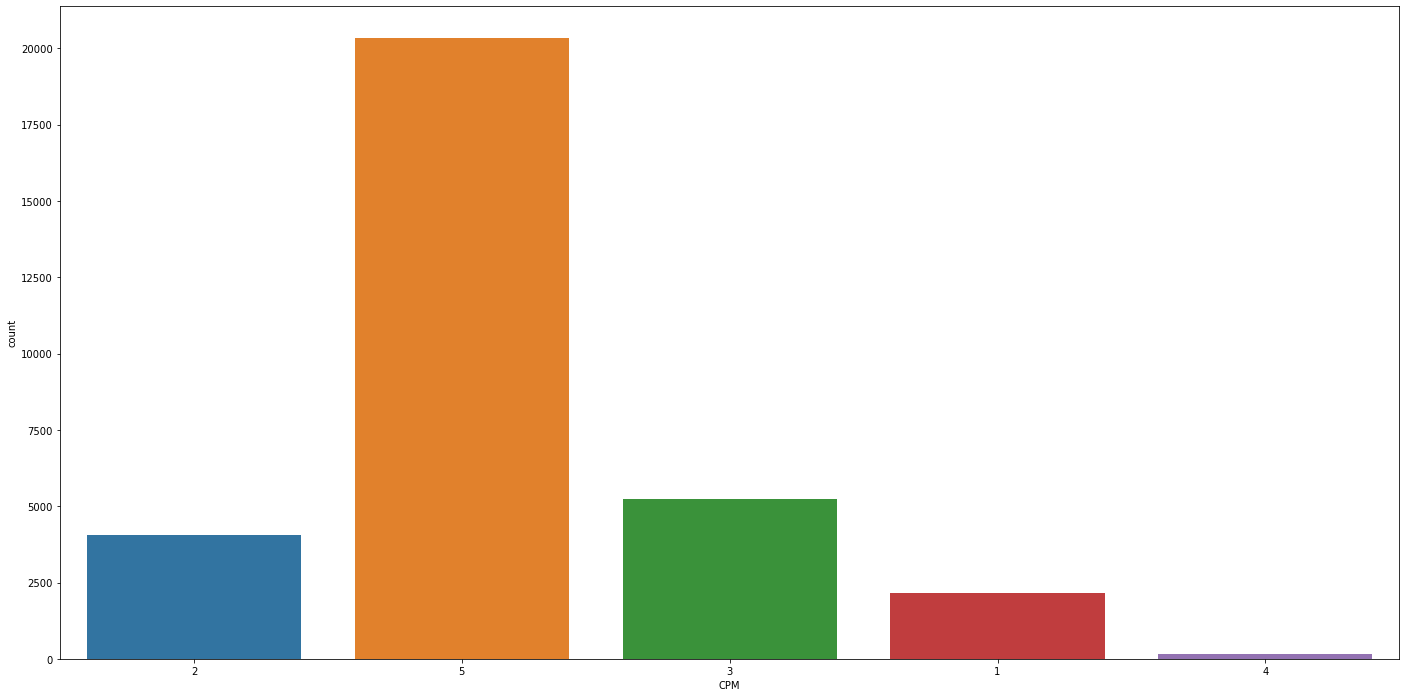

In [35]:
import matplotlib.pyplot as plt
import seaborn as sb
f, axes = plt.subplots(1, 1, figsize=(24, 12))
# sb.boxplot(data = df['CPM'].value_counts(), orient = "h", ax = axes[0])
# sb.histplot(data = df['CPM'].value_counts(), ax = axes[1])
# sb.violinplot(data = df['CPM'].value_counts(), orient = "h", ax = axes[2])
sb.countplot(df['CPM'])

C:\Users\root\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='CPM2', ylabel='count'>

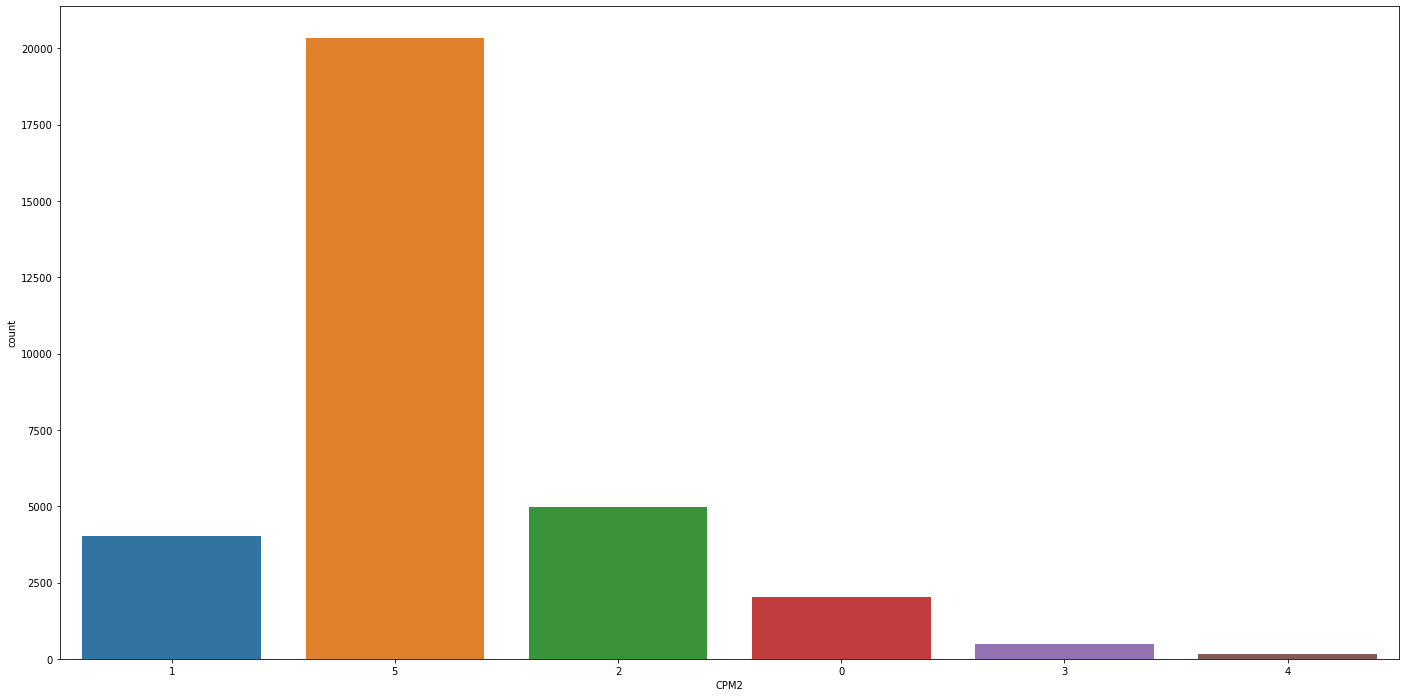

In [36]:
import matplotlib.pyplot as plt
import seaborn as sb
f, axes = plt.subplots(1, 1, figsize=(24, 12))
# sb.boxplot(data = df['CPM'].value_counts(), orient = "h", ax = axes[0])
# sb.histplot(data = df['CPM'].value_counts(), ax = axes[1])
# sb.violinplot(data = df['CPM'].value_counts(), orient = "h", ax = axes[2])
sb.countplot(df['CPM2'])

In [ ]:
# f, axes = plt.subplots(1, 3, figsize=(24, 12))
# sb.boxplot(data = df['CPM2'], orient = "h", ax = axes[0])
# sb.histplot(data = df['CPM2'], ax = axes[1])
# sb.violinplot(data = df['CPM2'], orient = "h", ax = axes[2])

In [ ]:
# f, axes = plt.subplots(1, 3, figsize=(24, 12))
# sb.boxplot(data = df['max_spend'], orient = "h", ax = axes[0])
# sb.histplot(data = df['max_spend'], ax = axes[1])
# sb.violinplot(data = df['max_spend'], orient = "h", ax = axes[2])

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(24, 12))
sb.boxplot(data = df['max_impressions'], orient = "h", ax = axes[0])
sb.histplot(data = df['max_impressions'], ax = axes[1])
sb.violinplot(data = df['max_impressions'], orient = "h", ax = axes[2])

In [37]:
type(df['CPM2'].iloc[0])

str

# Modelling


In [38]:
sum(df['delivery_period'].isna())

0

SHAPE
(25592, 2)
(6399, 2)
(25592, 1)
(6399, 1)


ValueError: could not convert string to float: '(4.5, 5.0]'

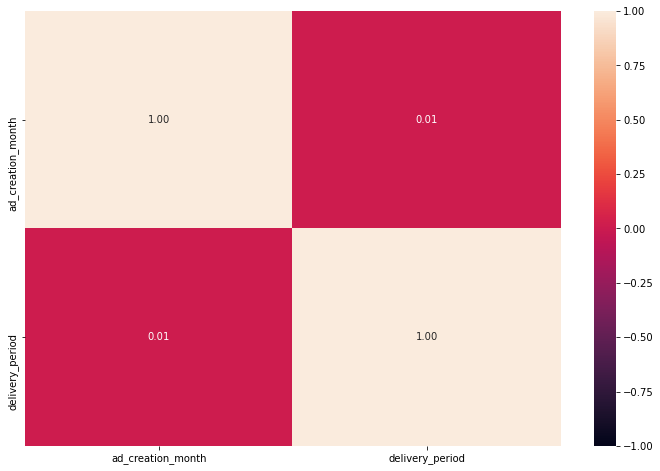

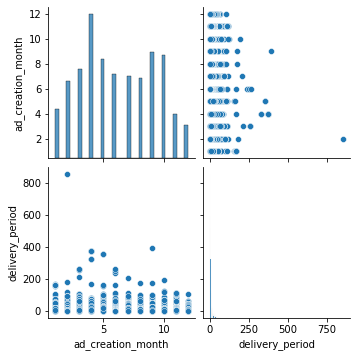

In [25]:
import matplotlib.pyplot as plt
import seaborn as sb

predictor=['ad_creation_month', 'delivery_period']
target=['CPM2']

X = df[predictor]
y = df[target]

DF = pd.concat([y, X], axis = 1).reindex(y.index)

f = plt.figure(figsize=(12, 8))
sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

sb.pairplot(data = DF)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error

print()
print("REPORT")
print(mean_squared_error(y_train, y_train_pred))
print(mean_squared_error(y_test, y_test_pred))

In [ ]:
df.columns

In [ ]:
df.dtypes

### XGB

In [40]:
predictor=['ad_creation_month', 'delivery_period']

from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
target=['CPM2']

X = df[predictor]
y = df[target]

y = y.astype('int64')

# y = LabelBinarizer().fit_transform(y)

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
xgb = XGBClassifier(n_estimators=100, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)

from sklearn.metrics import mean_squared_error, accuracy_score

print()
print("REPORT")
print("Train accuracy", accuracy_score(y_train, y_train_pred))
print("Test accuracy", accuracy_score(y_test, y_test_pred))

SHAPE
(25584, 2)
(6397, 2)
(25584, 1)
(6397, 1)
[10:20:22] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

REPORT
Train accuracy 0.6513836772983115
Test accuracy 0.6412380803501642


C:\Users\root\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [41]:
y.value_counts()

CPM2
5       20356
2        4962
1        4013
0        2009
3         483
4         158
dtype: int64

In [42]:
y_train.value_counts()

CPM2
5       16296
2        3986
1        3185
0        1599
3         387
4         131
dtype: int64

In [47]:
from catboost import CatBoostClassifier

predictor=['search_term', 'country', 'ad_creation_month', 'delivery_period']
target=['CPM2']

X = df[predictor]
y = df[target]

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

cat_features = ['search_term', 'country']

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=True
)



y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, roc_auc_score

print()
print("REPORT")
print('Accuracy score:')
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))
# print()
# print('Roc auc score:')
# print(roc_auc_score(y_train, clf.predict_proba(X_train), multi_class="ovr"))
# print(roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr"))
print()
print(classification_report(y_test, y_test_pred))

SHAPE
(25584, 4)
(6397, 4)
(25584, 1)
(6397, 1)
0:	learn: 1.6178202	test: 1.6211563	best: 1.6211563 (0)	total: 50.4ms	remaining: 202ms
1:	learn: 1.5032753	test: 1.5084670	best: 1.5084670 (1)	total: 98.2ms	remaining: 147ms
2:	learn: 1.4212003	test: 1.4281742	best: 1.4281742 (2)	total: 178ms	remaining: 119ms
3:	learn: 1.3584998	test: 1.3670501	best: 1.3670501 (3)	total: 250ms	remaining: 62.4ms
4:	learn: 1.3087033	test: 1.3184110	best: 1.3184110 (4)	total: 362ms	remaining: 0us

bestTest = 1.318411043
bestIteration = 4


REPORT
Accuracy score:
0.6381722951844903
0.6309207440987963

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       428
           1       0.00      0.00      0.00       802
           2       0.00      0.00      0.00      1004
           3       0.00      0.00      0.00        92
           4       0.00      0.00      0.00        35
           5       0.63      1.00      0.77      4036

    accuracy                       

C:\Users\root\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from catboost import CatBoostClassifier

predictor=['search_term', 'country', 'ad_creation_month', 'delivery_period']
target=['CPM']

X = df[predictor]
y = df[target]

# DF = pd.concat([y, X], axis = 1).reindex(y.index)

# f = plt.figure(figsize=(12, 8))
# sb.heatmap(DF.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")

# sb.pairplot(data = DF)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('SHAPE')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

clf = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)

cat_features = ['search_term', 'country']

clf.fit(X_train, y_train, 
        cat_features=cat_features, 
        eval_set=(X_test, y_test), 
        verbose=True
)



y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

from sklearn.metrics import mean_squared_error, accuracy_score

print()
print("REPORT")
print(accuracy_score(y_train, y_train_pred))
print(accuracy_score(y_test, y_test_pred))

In [48]:
df2 = df

In [51]:
df2.columns

Index(['search_term', 'country', 'page_id', 'page_name', 'ad_id',
       'ad_creation_date', 'ad_creation_month', 'delivery_start',
       'delivery_stop', 'delivery_period', 'ad_url', 'ad_body',
       'uses_multi_body', 'link_caption', 'uses_multi_capt', 'link_title',
       'uses_multi_title', 'link_description', 'uses_multi_desc', 'language',
       'uses_multi_lang', 'funded_by', 'currency', 'min_spend', 'max_spend',
       'min_impressions', 'max_impressions', 'min_audience_size',
       'max_audience_size', 'impressions', 'spend', 'CPM', 'CPM2', 'facebook',
       'instagram', 'messenger', 'audience_network', 'demographic_dist'],
      dtype='object')

In [52]:
df.iloc[0]

search_term                                                    ad-tech
country                                                             US
page_id                                                100470349235347
page_name                                                   Save Texas
ad_id                                                  762749274711708
ad_creation_date                                            2022-05-03
ad_creation_month                                                    5
delivery_start                                              2022-05-03
delivery_stop                                               2022-05-06
delivery_period                                                      3
ad_url               https://www.facebook.com/ads/archive/render_ad...
ad_body              In a technical report updated for the first ti...
uses_multi_body                                                      0
link_caption                                     oceanservice.noaa.gov
uses_m

In [68]:
df2 = df[df['uses_multi_body'] == 1]
df2.shape

(1072, 38)

In [71]:
pd.set_option('display.max_colwidth', None)
# dummy = pd.DataFrame(df2[df2['page_id'] == '131942223874']['ad_body'])
dummy = pd.DataFrame(df2['ad_body'])
dummy.head(1000)

,ad_body
43,"Patriotic Apparel is HERE! 🇺🇸\n\nWhen you wear one of our shirts, you’re letting people know that you’re not afraid to love your country; you’re not ashamed of being an American, you're proud to be an American.\n\nWe provide American quality without the B.S."
45,"Patriotic Apparel is HERE! 🇺🇸\n\nWhen you wear one of our shirts, you’re letting people know that you’re not afraid to love your country; you’re not ashamed of being an American, you're proud to be an American.\n\nWe provide American quality without the B.S."
78,"Patriotic Apparel is HERE! 🇺🇸\n\nWhen you wear one of our shirts, you’re letting people know that you’re not afraid to love your country; you’re not ashamed of being an American, you're proud to be an American.\n\n""Once you put this shirt on, you'll travel back in time to the days of our Founding Fathers. George Washington will shake your hand and by you a beer at the local tavern. (Not really) Shirt is made of quality material and feels great against my DadBod. I ordered a size up and it's a little big but overall I am very happy with my purchase.""\n\nWe provide American quality without the B.S."
79,"Patriotic Apparel is HERE! 🇺🇸\n\nWhen you wear one of our shirts, you’re letting people know that you’re not afraid to love your country; you’re not ashamed of being an American, you're proud to be an American.\n\n""Once you put this shirt on, you'll travel back in time to the days of our Founding Fathers. George Washington will shake your hand and by you a beer at the local tavern. (Not really) Shirt is made of quality material and feels great against my DadBod. I ordered a size up and it's a little big but overall I am very happy with my purchase.""\n\nWe provide American quality without the B.S."
395,"Americans need to get the government off their backs, so they can live life as they want and THRIVE. \n\nThe path to THRIVING includes school choice, VocTech training at both the high school level and for unemployed and underemployed adults, all of which Bobby Scott has consistently voted against."
...,...
38163,Moody's Analytics proyecta que una victoria de Joe Biden marcaría el comienzo de un mayor crecimiento económico y de empleo que con el presidente Trump.
38174,Moody's Analytics dice que el plan económico de Joe Biden crearía 7 millones de empleos más que el de Donald Trump.
38175,Moody's Analytics proyecta que una victoria de Joe Biden marcaría el comienzo de un mayor crecimiento económico y de empleo que bajo el presidente Trump.
38176,Moody's Analytics dice que el plan económico de Joe Biden crearía 7 millones de empleos más que el de Donald Trump.


In [1]:
df['ad_url']

NameError: name 'df' is not defined